# Masai - xto10x - Hackathon v2.0 - Data Analytics

This is the following file for the Python implenetation of data handling and creating a machine learning model based on the dataset.

*Dataset given to us - Aviation KPI*

The following task is given as:

In the airline industry, maximizing profitability is a complex challenge influenced by multiple operational and financial factors. Given historical flight performance data, your task is to develop a machine learning model that accurately predicts **profit (USD)** for each flight based on features such as:

- **Flight delays**
- **Aircraft utilization**
- **Turnaround time**
- **Load factor**
- **Fleet availability**
- **Maintenance downtime**
- **Fuel efficiency**
- **Revenue**
- **Operating costs**

And more….

---

### Your model must be robust enough to handle real-world uncertainties, including:

- **Seasonal fluctuations**
- **Operational inefficiencies**
- **Cost variations**

---

All while maintaining high predictive accuracy. Additionally, the model should provide **explainability** to help airline operators understand the key drivers of profitability and optimize decision-making.

The final model will be evaluated based on:

- **Prediction accuracy**
- **Interpretability**
- **Generalization to unseen data**

---

## **Objective**

Develop a **high-performance ML model** to predict airline profitability and provide actionable insights for operational optimization.

In [4]:
# Importing all the libraries that are essential for this task.
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Importing all the libraries to connect MySQL Database. 
from sqlalchemy import create_engine
import mysql.connector

In [3]:
# Loading the dataset into the task file. 
aviation_data = pd.read_csv("Aviation KPI.csv")
aviation_data

,Flight Number,Scheduled Departure Time,Actual Departure Time,Delay (Minutes),Aircraft Utilization (Hours/Day),Turnaround Time (Minutes),Load Factor (%),Fleet Availability (%),Maintenance Downtime (Hours),Fuel Efficiency (ASK),Revenue (USD),Operating Cost (USD),Net Profit Margin (%),Ancillary Revenue (USD),Debt-to-Equity Ratio,Revenue per ASK,Cost per ASK,Profit (USD)
0,FL885,2024-05-20 11:51:21,2024-07-10 02:38:54,50,12.36,115,79.18,96.24,9.21,4.15,10953.75,27847.59,17.90,1058.68,2.46,2639.46,6710.26,-16893.84
1,FL930,2024-01-23 06:56:23,2024-07-07 02:53:44,27,14.53,83,98.59,80.49,1.55,3.93,31597.25,1564.41,7.70,2941.32,2.89,8040.01,398.07,30032.84
2,FL478,2024-05-30 09:18:39,2024-12-05 01:00:54,108,10.73,87,67.44,97.90,2.06,4.26,13700.27,30494.88,5.84,1920.45,1.34,3216.03,7158.42,-16794.61
3,FL637,2024-08-15 05:21:47,2024-09-21 13:23:42,64,15.10,99,69.01,80.17,6.85,4.13,39913.01,13444.09,24.09,3167.79,0.60,9664.17,3255.23,26468.92
4,FL318,2024-07-25 15:29:58,2024-03-21 15:05:54,30,13.46,114,50.36,82.23,7.30,4.97,11531.48,34668.98,7.18,619.80,0.84,2320.22,6975.65,-23137.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,FL073,2024-09-04 21:05:15,2024-01-13 21:04:10,28,14.86,38,60.12,97.56,8.44,2.16,20903.43,11668.11,24.11,856.06,0.53,9677.51,5401.90,9235.32
199996,FL732,2024-01-25 21:17:59,2024-01-21 00:57:55,48,8.67,34,77.77,87.05,8.13,3.26,39601.03,29873.77,7.33,1037.92,1.31,12147.56,9163.73,9727.26
199997,FL519,2024-10-19 08:31:24,2024-06-04 03:40:50,83,12.80,58,93.12,80.84,9.80,3.68,36100.34,16114.79,21.82,1441.99,2.69,9809.87,4379.02,19985.55
199998,FL585,2024-01-04 04:35:20,2024-02-06 01:57:18,55,12.53,115,99.04,85.82,6.84,4.70,8157.56,15878.50,17.93,4584.92,1.26,1735.65,3378.40,-7720.94


In [4]:
# Converting the datetime columns into panda formatted datetime columns. 
aviation_data['Scheduled Departure Time'] = pd.to_datetime(aviation_data['Scheduled Departure Time'])
aviation_data['Actual Departure Time'] = pd.to_datetime(aviation_data['Actual Departure Time'])

In [5]:
# Extracting time-based features from the dataset. 
aviation_data['Month'] = aviation_data['Scheduled Departure Time'].dt.month
aviation_data['Day of Week'] = aviation_data['Scheduled Departure Time'].dt.dayofweek
aviation_data['Hour'] = aviation_data['Scheduled Departure Time'].dt.hour
aviation_data['Season'] = aviation_data['Scheduled Departure Time'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

In [6]:
# Refining the interaction features. 
aviation_data['Utlization x Load Factor'] = aviation_data['Aircraft Utilization (Hours/Day)'] * aviation_data['Load Factor (%)']
aviation_data['Cost Efficiency x Fuel'] = aviation_data['Cost per ASK'] * aviation_data['Fuel Efficiency (ASK)']
aviation_data['Revenue per ASK x Fleet Availability'] = aviation_data['Revenue per ASK'] * aviation_data['Fleet Availability (%)']
aviation_data['Turnaround x Delay'] = aviation_data['Turnaround Time (Minutes)'] * aviation_data['Delay (Minutes)']

In [7]:
# Reintroducing essential features without direct data leakage. 
aviation_data['Revenue per ASK'] = aviation_data['Revenue (USD)'] / aviation_data['Aircraft Utilization (Hours/Day)']
aviation_data['Cost per ASK'] = aviation_data['Operating Cost (USD)'] / aviation_data['Aircraft Utilization (Hours/Day)']
aviation_data['Ancillary Revenue (USD)'] = aviation_data['Ancillary Revenue (USD)']
aviation_data['Net Profit Margin (%)'] = aviation_data['Net Profit Margin (%)']

In [8]:
# Ensuring that the profit (USD) has only positive values for log transformation. 
min_profit = aviation_data['Profit (USD)'].min()
if min_profit <= 0:
    shift_value = abs(min_profit) + 1
    aviation_data['Log_Profit'] = np.log1p(aviation_data['Profit (USD)'] + shift_value)
else:
    aviation_data['Log_Profit'] = np.log1p(aviation_data['Profit (USD)'])
aviation_data.drop(columns = ['Profit (USD)'], inplace = True)    

In [9]:
# Dropping the highly correlated features to avoid data leakage. 
aviation_data.drop(columns = ['Flight Number', 'Scheduled Departure Time', 'Actual Departure Time', 'Revenue (USD)', 'Operating Cost (USD)'], inplace = True)

In [10]:
# One-Hot Encoding the Categorical Feature "Season". 
aviation_data = pd.get_dummies(aviation_data, columns = ['Season'], drop_first = True)

In [11]:
# Splitting the dataset into training and testing sets. 
x = aviation_data.drop(columns = ['Log_Profit'])
y = aviation_data['Log_Profit']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [12]:
# Standardizing the features before applying Ridge Regression.
ridge_model = make_pipeline(StandardScaler(), RidgeCV(alphas = [0.1, 1, 10, 50, 100]))

In [13]:
# Training the model. 
ridge_model.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=[0.1, 1, 10, 50, 100]))])

In [14]:
# Making the predictions with the help of our model. 
y_pred_log = ridge_model.predict(x_test)
y_pred = np.expm1(y_pred_log) - shift_value

In [15]:
# Evaluating the performance. 
rmse = mean_squared_error(np.expm1(y_test) - shift_value, y_pred) ** 0.5
r2 = r2_score(np.expm1(y_test) - shift_value, y_pred)

# Displaying the values. 
print(f'Ridge Regression RMSE Value is: {rmse}')
print(f'Ridge Regression R-Square Value is: {r2}')

Ridge Regression RMSE Value is: 8195.023691328219
Ridge Regression R-Square Value is: 0.7940487025320211


In [17]:
# Checking out for overfitting scores using Cross-Validation. 
cv_scores = cross_val_score(ridge_model, x_train, y_train, cv = 5, scoring = 'r2')

# Displaying the cross-validation results. 
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f'Cross-Validation R-Squared Mean is: {cv_mean}')
print(f'Cross-Validation R-Squared STD Value is: {cv_std}')

Cross-Validation R-Squared Mean is: 0.8526914169101838
Cross-Validation R-Squared STD Value is: 0.004157039526272716


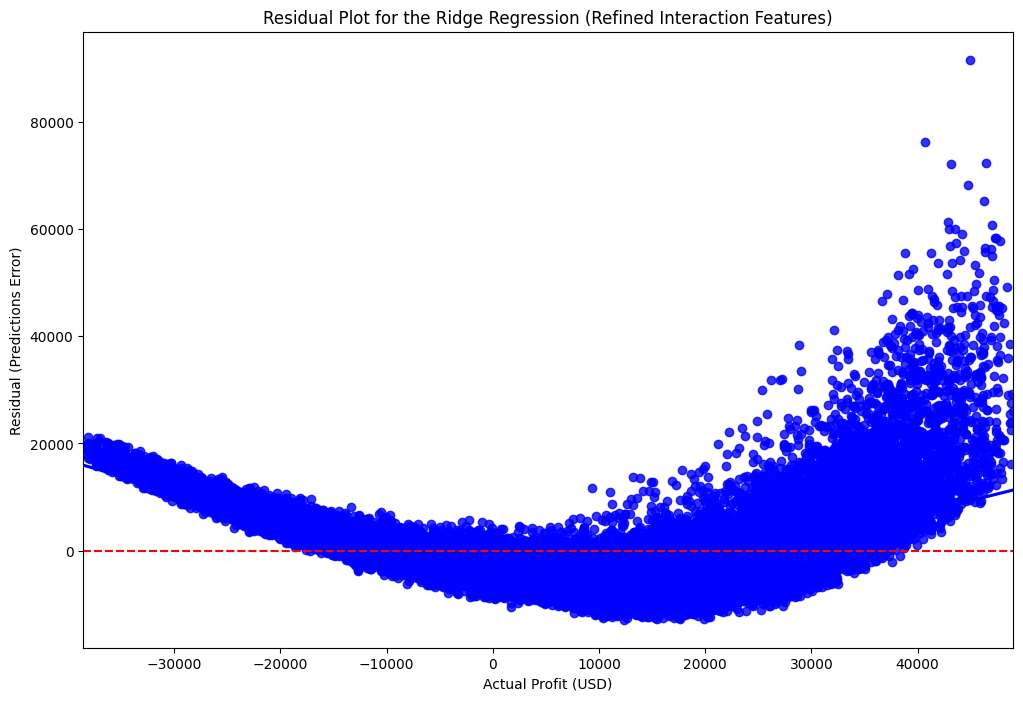

In [18]:
# Creating a residual plot for the model values.
plt.figure(figsize = (12, 8))
sns.residplot(x = np.expm1(y_test) - shift_value, y = y_pred - (np.expm1(y_test) - shift_value), lowess = True, color = 'blue')
plt.axhline(0, color = 'red', linestyle = '--')
plt.xlabel('Actual Profit (USD)')
plt.ylabel('Residual (Predictions Error)')
plt.title('Residual Plot for the Ridge Regression (Refined Interaction Features)')
plt.show()